# Modelo de Clusterización
* Modelo enfocado a detectar **posibles clusters** o diferentes grupos de clientes


## Librerias

In [1]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import seaborn as sns # importando seaborn
# Librería para obtener correlación
import scipy.stats as ss
# Librería para obtener todas las combinaciones (c/repetidos) de una lista
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle


from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


## Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
HT_PATH = '/content/drive/MyDrive/Hackaton BBVA/Tablas_guardadas'
VR_PATH = '/content/drive/MyDrive/Reto Vinculación rentable'

#Dejar todo a dos puntos decimales
pd.options.display.float_format = "{:.2f}".format


#Crgar archivo de info
path = HT_PATH + "/otros_morales.csv"
df = pd.read_csv(path)
df = df.drop(columns=["Unnamed: 0"])

In [4]:
# Variables categoricas
#df.dtypes
cat = [
"GENERO",
"ESTADO_CIVIL",
"AFILIACION_SMS",
"AFILIACION_BANCA_ONLINE"
]

In [5]:
dummy = pd.get_dummies(df[cat])
df = df.drop(columns=cat)
df = df.fillna(0)
df = pd.concat([df,dummy], axis=1)

In [6]:
ids_cols = ['CODIGO_CLIENTE']

fis_d = df.describe()
var_con = [x for x in df.columns if x in list(fis_d.columns)+ids_cols]

df = df[var_con]

In [7]:
len(list(df.columns))

77

## Correlaciones

In [8]:
umbral_corr = 0.75
alfa = df.corr().melt()
alfa = alfa[(abs(alfa.value) > umbral_corr) & (abs(alfa.value) < 1) ]
len(alfa)

16

In [9]:
var_alta_corr = df.loc[:,list(alfa["variable"])]
data1 = var_alta_corr.corr()
corr = data1.corr("pearson")

In [10]:
# Creamos una matriz de Coorelación positiva
data2 = df.corr().abs()

# Creamos una mascara booleana
mask = np.triu(np.ones_like(data2, dtype=bool))
tri_df = data2.mask(mask)
tri_df

# Lista to drop
to_drop = [c for c in tri_df.columns if any (tri_df[c] > umbral_corr)]
# Borrar var correlacionadas del DF
df = df.drop(to_drop, axis=1)

## Normalización

In [11]:
# Definir variables de entrada
X = df.iloc[:,0:df.shape[1]].values 

# Aplicar Normalización: Standard Scaler

# Creamos el Objeto de Escalamiento
std_scaler = StandardScaler()

# aplicamos fit y transform a la data 
X = X_std = std_scaler.fit_transform(X)

## Método del Codo

In [12]:
max_k = 10    ## maximo número de clusters que vamos a crear

ssw = []

for k in range(1,max_k+1):
    kmeanModel = KMeans(n_clusters=k).fit(X)
    centers = pd.DataFrame(kmeanModel.cluster_centers_)
    labels = kmeanModel.labels_
    ssw_k = sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1))
    ssw.append(ssw_k)

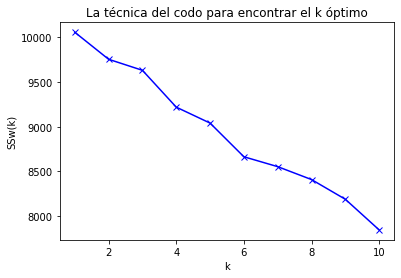

In [13]:
#Representación del codo
plt.plot(range(1,max_k+1), ssw, "bx-")
plt.xlabel("k")
plt.ylabel("SSw(k)")
plt.title("La técnica del codo para encontrar el k óptimo")
plt.show()

## Clusters

In [16]:
kmeanModel = KMeans(n_clusters=6).fit(X)

centers = pd.DataFrame(kmeanModel.cluster_centers_)
labels = kmeanModel.labels_
df["labels"] = labels

In [17]:
beta = df.groupby(["labels"]).mean()
beta = beta[["EDAD", "SALDO_MEDIO_VISTA", "SALDO_MEDIO_AUTOS", "SALDO_MEDIO_TARJETAS", "HIPOTECARIO_RENT_PROD", 
             "AUTOS_RENT_PROD", "CARTERA_RENT_PROD", "COMEXT_RENT_PROD", "CONSUMO_RENT_PROD", "LEASING_RENT_PROD",
             "NO_PRODUCTOS_RENT_PROD", "FAM_GLOBAL","NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD", "DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD",
             "ABANDONO","ATT","VINCULACION_PN"]]

beta

,EDAD,SALDO_MEDIO_VISTA,SALDO_MEDIO_AUTOS,SALDO_MEDIO_TARJETAS,HIPOTECARIO_RENT_PROD,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,LEASING_RENT_PROD,NO_PRODUCTOS_RENT_PROD,FAM_GLOBAL,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,ABANDONO,ATT,VINCULACION_PN
labels,,,,,,,,,,,,,,,,,
0,16.02,0.00,0.00,0.00,0.00,0.00,1.00,0.28,0.00,0.28,3.56,0.05,0.00,0.00,0.00,0.31,0.00
1,9.92,873.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,-154.13,0.78,0.00,0.12,0.00
2,40.68,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.45,0.00
3,11.07,4989.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,1.02,1.70,17.47,10.92,0.00,0.18,0.00
4,11.73,1095.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.22,-6.98,0.00,0.00,0.34,0.00
5,9.96,1190.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.30,-14.32,0.23,0.00,0.19,0.00


**Grupo 0: Jovenes**
*Alta Transaccionalidad y Costosos al Banco*

* Tienen auto
* Pocos Productos
* Saldo medio en tajetas
* Son rentables
* Son costozos al banco
* Abandono maximo de un mes
* Altamente vinciulados

**Grupo 1: Totaleros**
*Solo usan productos de consumo en pequeña cantidad*

* Jovenes
* Poco Saldo Medio
* Rentabilidad baja para el banco
* Poca inversion de parte del banco
* Uso constante de servicos del banco
* Pocos productos, principalmente de consumo

**Grupo 2: Deudor**
*Personas con deudas y alta transaccionalidad*

* Poco Saldo Medio a la Vista
* Deudas en tarjetas
* Cuentan con productos hipotecarios
* No tienen auto, pero rentan autos
* Tienen varios productos con el banco
* Baja liquidez para el banco

**Grupo 3: De Oportunidad**
*Clientes que compran en ofertas o productos de credito por temporadas*

* Saldo Medio a la Vista Comun 
* Tienen auto
* Son los que tienen mayor uso de tarjetas
* No les gusta deber
* Poca vinculación
* Periodos largos de inactividad
* No tan vinculados

**Grupo 4: Potencial**
*Clientes con dinero y no tantos productos*

* Tienen dinero
* Tienen Auto
* Deben tarjetas
* Tardan un poco en pagar
* Tienen mal ratio de rentabilidad
* Periodos largos de Inactividad
* Poca vinculación

**Grupo 5: Desatendido**
*Clientes con mayor edad y con poca atención al banco*

* Son los de mayor de edad
* Los que tienen menos productos
* Son los que tardan más en pagar
* Los de menos vinculación
* Los de mayor desatención
* Rentables
* No dejan dinero en su cuenta 


In [ ]:
# Guardado 
beta.to_csv(HT_PATH + "/bbva_fisicas_mean.csv")
df.to_csv(HT_PATH + "/bbva_fisicas_cl.csv")

In [ ]:
# Pickle
pkl_filename = HT_PATH + "fisicas_pickle.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeanModel, file)